Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
7 7
3136 128
128 50
i: 0 j: 0 nb: 332 cost: 2.43932 error rate: 0.766666666667
i: 0 j: 20 nb: 332 cost: 1.8948 error rate: 0.466666666667
i: 0 j: 40 nb: 332 cost: 1.54635 error rate: 0.266666666667
i: 0 j: 60 nb: 332 cost: 1.81809 error rate: 0.2
i: 0 j: 80 nb: 332 cost: 1.3968 error rate: 0.2
i: 0 j: 100 nb: 332 cost: 1.46323 error rate: 0.133333333333
i: 0 j: 120 nb: 332 cost: 1.36297 error rate: 0.133333333333
i: 0 j: 140 nb: 332 cost: 1.04378 error rate: 0.0666666666667
i: 0 j: 160 nb: 332 cost: 1.23129 error rate: 0.0666666666667
i: 0 j: 180 nb: 332 cost: 1.16257 error rate: 0.1
i: 0 j: 200 nb: 332 cost: 1.2409 error rate: 0.133333333333
i: 0 j: 220 nb: 332 cost: 1.16209 error rate: 0.0333333333333
i: 0 j: 240 nb: 332 cost: 1.29586 error rate: 0.0666666666667
i: 0 j: 260 nb: 332 cost: 1.106

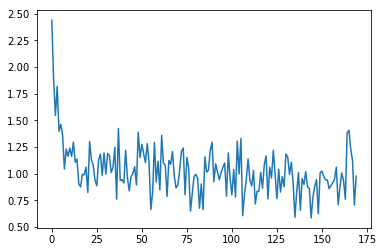

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from util import *



class logistic(object):
	def __init__(self,mnist):
		self.mnist=mnist
		self.x=tf.placeholder(tf.float32,shape=[None,784])
		self.T=tf.placeholder(tf.float32,shape=[None,10])
		self.W=tf.Variable(tf.zeros([784,10]))
		self.b=tf.Variable(tf.zeros([10]))


	def fit(self):
		self.y=self.forward(self.x)
		cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.T,logits=self.y))
		train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
		with tf.Session() as sess:
			sess.run(tf.global_variables_initializer())
			for _ in range(1000):
			    batch = self.mnist.train.next_batch(100)
			    sess.run(train_step, feed_dict={self.x: batch[0], self.T: batch[1]})
			correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.T,1))
			accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
			print(accuracy.eval(feed_dict={self.x: self.mnist.test.images, self.T: self.mnist.test.labels}))


	def predict(self,x):
		act=self.forward(x)
		return tf.argmax(act,1)


	def forward(self,x):
		return tf.matmul(x,self.W) + self.b

class HiddenLayer(object):
	def __init__(self,M1,M2,id):
		self.id=id
		self.M1=M1
		self.M2=M2
		w,b=init_weight_and_bias(M1,M2)
		self.W=tf.Variable(w.astype(np.float32))
		self.b=tf.Variable(b.astype(np.float32))
		self.params=[self.W,self.b]

	def forward(self,X):
		return tf.nn.relu(tf.matmul(X,self.W)+self.b)

class ANN(object):
	def __init__(self,hidden_layer_sizes,mnist):
		self.hidden_layer_sizes=hidden_layer_sizes
		self.x=tf.placeholder(tf.float32,shape=[None,784])
		self.T=tf.placeholder(tf.float32,shape=[None,10])
		self.mnist=mnist

	def fit(self,lr=10e-5, mu=0.99, decay=0.999, reg=10e-3, epochs=100, batch_sz=100, show_fig=True):
		N,D=self.mnist.test.images.shape
		self.hidden_layers=[]
		M1=D
		count=0
		for M2 in self.hidden_layer_sizes:
			h=HiddenLayer(M1,M2,count)
			# print("hidden",M1,M2)
			M1=M2
			count+=1
			self.hidden_layers.append(h)
		K=10
		W,b=init_weight_and_bias(M1,K)
		# print("output",M1,K)
		self.W = tf.Variable(W.astype(np.float32))
		self.b = tf.Variable(b.astype(np.float32))
		self.params = [self.W, self.b]
		for h in self.hidden_layers:
			self.params += h.params
		self.y=self.forward(self.x)
		
		Xvalid=self.mnist.test.images[-batch_sz:]
		Yvalid=self.mnist.test.labels[-batch_sz:]
		Yvalid_flat = np.argmax(Yvalid, axis=1)
		rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
		cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.y,labels=self.T))+rcost
		train_step = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(cost)
		prediction = self.predict(self.x)
		init = tf.global_variables_initializer()
		n_batches = N // batch_sz
		costs=[]
		with tf.Session() as sess:
			sess.run(init)
			for i in range(epochs):
				for j in range(n_batches-1):
					batch = self.mnist.train.next_batch(batch_sz)
					sess.run(train_step, feed_dict={self.x: batch[0], self.T: batch[1]})
					if j % 20 == 0:
						c = sess.run(cost, feed_dict={self.x: Xvalid, self.T: Yvalid})
						costs.append(c)
						p = sess.run(prediction, feed_dict={self.x: Xvalid, self.T: Yvalid})
						e = error_rate(Yvalid_flat, p)
						# correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.T,1))
						# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
						# e= accuracy.eval(feed_dict={self.x: Xvalid, self.T: Yvalid})
						print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
		if show_fig:
			plt.plot(costs)
			plt.show()			

	def forward(self,X):
		Z=X
		for h in self.hidden_layers:
			Z=h.forward(Z)
			# print(h.M1,h.M2,Z)
		return tf.matmul(Z,self.W)+self.b

	def predict(self,X):
		act=self.forward(X)
		return tf.argmax(act,1)


def init_filter(shape, poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
    return w.astype(np.float32)


class ConvPoolLayer(object):
	def __init__(self,inputSize,outputSize,fw=5,fh=5,poolsize=(2,2)):
		self.W=tf.Variable(init_filter((fw,fh,inputSize,outputSize),poolsize))
		self.b=tf.Variable(np.zeros(outputSize,dtype=np.float32))
		self.poolsize=poolsize
		self.params=[self.W,self.b]
		self.inputSize=inputSize
		self.outputSize=outputSize

	def forward(self,X):
		conv_out=tf.nn.conv2d(X,self.W,strides=[1,1,1,1],padding="SAME")
		conv_out=tf.nn.bias_add(conv_out,self.b)
		pool_out=tf.nn.max_pool(conv_out,
			ksize=[1,self.poolsize[0],self.poolsize[1],1],
			strides=[1,self.poolsize[0],self.poolsize[1],1],
			padding="SAME")
		return tf.nn.relu(pool_out)

class CNN(object):
	def __init__(self,convpool_layer_sizes,hidden_layer_sizes,mnist):
		self.convpool_layer_sizes=convpool_layer_sizes
		self.hidden_layer_sizes=hidden_layer_sizes
		self.x=tf.placeholder(tf.float32,shape=[None,28,28,1],name="X")
		self.T=tf.placeholder(tf.float32,shape=[None,10],name="Y")
		
		self.mnist=mnist

	def fit(self,lr=10e-4, mu=0.99,reg=10e-4,decay=0.9999,eps=10e-3,batch_sz=30,epochs=10,show_fig=True):
		
		N,D=self.mnist.test.images[:-batch_sz].shape
		width=28
		height=28
		channel=1
		self.hidden_layers=[]
		self.convpool_layers=[]
		mi=channel
		count=0
		outwidth=width
		outheight=height

		#convPool layers
		for mo,fw,fh in self.convpool_layer_sizes:
			layer=ConvPoolLayer(mi,mo,fw,fh)
			self.convpool_layers.append(layer)
			outwidth=outwidth//2
			outheight=outheight//2
			mi=mo
		#flatten
		print(outwidth,outheight)
		M1=self.convpool_layer_sizes[-1][0]*outwidth*outheight
		count=0

		#hidden full connnected layers
		for M2 in self.hidden_layer_sizes:
			print(M1,M2)
			h=HiddenLayer(M1,M2,count)
			# print("hidden",M1,M2)
			M1=M2
			count+=1
			self.hidden_layers.append(h)

		K=10
		W,b=init_weight_and_bias(M1,K)
		# print("output",M1,K)
		self.W = tf.Variable(W.astype(np.float32))
		self.b = tf.Variable(b.astype(np.float32))
		self.params = [self.W, self.b]
		for h in self.convpool_layers:
			self.params += h.params
		for h in self.hidden_layers:
			self.params += h.params
		self.y=self.forward(self.x)

		keep_prob = tf.placeholder(tf.float32)
		self.y = tf.nn.dropout(self.y, keep_prob)
		
		Xvalid=self.mnist.test.images[-batch_sz:]
		Yvalid=self.mnist.test.labels[-batch_sz:]
		Yvalid_flat = np.argmax(Yvalid, axis=1)
		rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
		cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.y,labels=self.T))+rcost
		train_step = tf.train.AdamOptimizer(lr).minimize(cost)
		prediction = self.predict(self.x)
		init = tf.global_variables_initializer()
		n_batches = N // batch_sz
		costs=[]
		with tf.Session() as sess:
			sess.run(init)
			for i in range(epochs):
				for j in range(n_batches-1):
					batch = self.mnist.train.next_batch(batch_sz)
					sess.run(train_step, feed_dict={self.x: np.reshape(batch[0],[batch_sz,28,28,1]), self.T: batch[1],keep_prob: 0.5})
					if j % 20 == 0:
						c = sess.run(cost, feed_dict={self.x: np.reshape(Xvalid,[batch_sz,28,28,1]), self.T: Yvalid,keep_prob: 0.5})
						costs.append(c)
						p = sess.run(prediction, feed_dict={self.x: np.reshape(Xvalid,[batch_sz,28,28,1]), self.T: Yvalid,keep_prob: 0.5})
						e = error_rate(Yvalid_flat, p)
						# correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.T,1))
						# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
						# e= accuracy.eval(feed_dict={self.x: Xvalid, self.T: Yvalid})
						print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
		if show_fig:
			plt.plot(costs)
			plt.show()		

	

	def forward(self,X):
		Z=X
		for c in self.convpool_layers:
			Z=c.forward(Z)
		Z_shape=Z.get_shape().as_list()
		Z = tf.reshape(Z, [-1, np.prod(Z_shape[1:])])
		for h in self.hidden_layers:
			Z=h.forward(Z)
		return tf.matmul(Z,self.W)+self.b


	def predict(self,X):
		act=self.forward(X)
		return tf.argmax(act,1)



mnist=input_data.read_data_sets('MNIST_data',one_hot=True)
# model=logistic(mnist)
#model=ANN([100,50],mnist)
model = CNN([(32, 5, 5), (64, 5, 5)],[128,50],mnist)
model.fit()

In [4]:
len(costs)

NameError: name 'costs' is not defined